# Interferometry with coherent states using parity operator

In [3]:
%matplotlib inline

from math import *
from qutip import *
from pylab import *

from scipy.optimize import minimize as cp_minimize

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

### Symbols & operators

In [4]:
T = sp.symbols('T')
N = 60 # dimension of the Hilbert space

# operators
I = qeye(N) # identity operator
a = destroy(N) # annihilation operator
n = num(N); n_a = tensor(n, I); n_b = tensor(I, n) # number operators
D_n = n_a - n_b # ΔN = n_1 - n_2
S_n = n_a + n_b # ΣN = n_1 + n_2
U = (1j*np.pi/4*(tensor(a.dag(), a) + tensor(a, a.dag()))).expm() # beam splitter operator

# Schwinger representation
Jx = 1/2*(tensor(a.dag(), a) + tensor(a, a.dag()))
Jy = -1j/2*(tensor(a.dag(), a) - tensor(a, a.dag()))
Jz = 1/2*(tensor(a.dag()*a, I) - tensor(I, a.dag()*a))

# Parity operator
Pa = (1j*np.pi*tensor(a.dag()*a,I)).expm()
Pb = (1j*np.pi*tensor(I,a.dag()*a)).expm()
P = (1j*np.pi*a.dag()*a).expm()

#### Checking that $\hat{P}$ works properly

In [3]:
psi_10 = tensor(fock(N,1),fock(N,0))
psi_01 = tensor(fock(N,0),fock(N,1))
psi_11 = tensor(fock(N,1),fock(N,1))
psi_12 = tensor(fock(N,1),fock(N,2))
psi_21 = tensor(fock(N,2),fock(N,1))
psi_22 = tensor(fock(N,2),fock(N,2))
#print(psi_10,psi_01,psi_11,psi_12,psi_21,psi_22)

PP = Pa*Pb
#print(PP*psi_10,PP*psi_01,PP*psi_11,PP*psi_12,PP*psi_21,PP*psi_22)

In [5]:
psi_0 = fock(N,0)
psi_1 = fock(N,1)
psi_2 = fock(N,2)
#print(psi_0,psi_1,psi_2)

#print(P*psi_0,P*psi_1,P*psi_2)

In [7]:
rho_test = 0.4*fock(N,0)*fock(N,0).dag() + 0.6*fock(N,1)*fock(N,1).dag()
(rho_test*P).tr()

-0.19999999999999996

### Functions for input states

In [4]:
# returns ρ_in given pure state ψ_in
def rho(psi):
    return psi*psi.dag()

# |ψ_in_1> = |0>|α>
def psi_in_1(alpha):
    return tensor(fock(N, 0),coherent(N, alpha))

# |ψ_in_2> = |β>|β>
def psi_in_2(beta):
    return tensor(coherent(N, beta),coherent(N, beta))
    
# |ψ_in_3> = N(|γδ>+|δγ>)
def psi_in_3(gamma, delta):
    temp = tensor(coherent(N, gamma), coherent(N, delta)) + tensor(coherent(N, delta), coherent(N, gamma))
    return temp.unit()

# |ψ_in_4> = N(a_1†|α_1,α_2>+a_2†|α_1,α_2>)
def psi_in_4(alpha_1, alpha_2):
    psi_alphas = tensor(coherent(N, alpha_1),coherent(N, alpha_2)) # |α_1,α_2>
    temp = tensor(a.dag(), I)*psi_alphas + tensor(I, a.dag())*psi_alphas
    return temp.unit()
    
# |ψ_in_5> = N(a_1†²|α_1,α_2>+a_2†²|α_1,α_2>)    
def psi_in_5(alpha_1, alpha_2):
    psi_alphas = tensor(coherent(N, alpha_1), coherent(N, alpha_2)) # |α_1,α_2>
    temp = tensor(a.dag()**2, I)*psi_alphas + tensor(I, a.dag()**2)*psi_alphas
    return temp.unit()

### Helper functions

In [5]:
# returns an np-array matrix given Qobj
def Qobj_to_np_array(Qobj):
    M = []
    for i in Qobj:
        M.append(i)
    return np.resize(np.asarray(M), np.shape(Qobj))

# returns a sp-array matrix given Qobj
def Qobj_to_sp_array(Qobj):
    return sp.Matrix(Qobj_to_np_array(Qobj))

# returns the minimum value of expr(var)
def minimizer(expr, var):
    f = sp.lambdify(var, expr)
    res = cp_minimize(f, 1)
    return res.fun

# differentiation using forward difference (fd)
def der_fd_abs(func, d_t):
    der = []
    for i in range(0, len(func)-1):
        der.append(abs((func[i+1]-func[i])/d_t))
    return der

# differentiation using central difference (cd)
def der_cd_abs(func, d_t):
    der = []
    for i in range(1, len(func)-1):
        der.append(abs((func[i+1]-func[i-1])/(2*d_t)))
    return der

#### Checking differentiation methods work properly

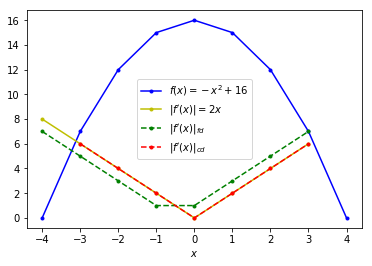

In [6]:
quadratic = [0,7,12,15,16,15,12,7,0]
x_min = -4; x_max = 4; d_t = 1

der_quadratic_fd = der_fd_abs(quadratic, d_t)
der_quadratic_cd = der_cd_abs(quadratic, d_t)

plt.plot(arange(x_min, x_max+d_t, d_t), quadratic, 'b.-', label=r'$f(x)=-x^2+16$')
x = arange(x_min , x_max, d_t)
plt.plot(x, abs(2*x), 'y.-', label=r'$|f^\prime(x)|=2x$')

plt.plot(arange(x_min, x_max, d_t), der_quadratic_fd, 'g.--', label=r'$|f^\prime(x)|_{fd}$')
plt.plot(arange(x_min+d_t, x_max, d_t), der_quadratic_cd, 'r.--', label=r'$|f^\prime(x)|_{cd}$')

plt.xlabel(r'$x$')
plt.legend(loc='best')

#plt.close()

## Numerical Heisenberg picture 2

### Functions returning $\Delta\phi$ using $\hat{P}$

In [6]:
def phi_std_dev(rho_in):
    # ΔP
    Pa_std_dev = np.sqrt(1 - (rho_in*Pa).tr()**2)
    
    # |d<P_a>_out/dφ|
    result = []
    for t in arange(-0.01, 2*np.pi, 0.3):
        MZI = (-1j*Jy*t).expm();
        dMZI_dt = (-1j*Jy)*(-1j*Jy*t).expm();
        
        Pa_out = dMZI_dt.dag()*Pa*MZI + MZI.dag()*Pa*dMZI_dt;
        
        value = np.abs((rho_in*Pa_out).tr())
        print(value)
        result.append(value)
        
    return(Pa_std_dev/np.array(result))

#### Caculating & plotting $\Delta\phi_\text{min}$ vs. $\langle n \rangle$ using $\hat{P} = (-1)^{\hat{N_1}}$

In [9]:
file = open("parity_numerical_Heisenberg_2_12.txt","w+")
file.write("# Δφ_min calculated using parity operator and numerical Heisenberg method\n")
file.write("# |ψ_in_1> = |0>|α>\n")
file.write("# |ψ_in_2> = |β>|β>\n")
file.write("# ------------------------------------------------------------------------------------------------\n")
file.write("# %-10s %-30s %-10s %-30s\n" % ("alpha","Δφ_min_1","beta","Δφ_min_2"))

86

In [1]:
n_1_avgs = []; phi_1_std_dev_mins = []
n_2_avgs = []; phi_2_std_dev_mins = []

alphas = [0.5*n for n in range (1,11)] # {0.5, 1, 1.5 ... 5}

for alpha in alphas:
    beta = np.sqrt(alpha**2/2)
    
    rho_in_1 = rho(psi_in_1(alpha))
    rho_in_2 = rho(psi_in_2(beta))
    
    # <n>'s
    n_1_avgs.append(np.abs((rho_in_1*S_n).tr()))
    n_2_avgs.append(np.abs((rho_in_2*S_n).tr()))
    
    # Δφ_min's
    phi_1_std_dev = phi_std_dev(rho_in_1)
    min_1 = np.amin(phi_1_std_dev)
    phi_1_std_dev_mins.append(min_1)
    
    
    phi_2_std_dev = phi_std_dev(rho_in_2)
    min_2 = np.amin(phi_2_std_dev)
    phi_2_std_dev_mins.append(min_2)
    
    file.write("  %-10.8f %-30.25f %-10.8f %-30.25f\n" % (alpha,min_1,beta,min_2))
    print("alpha =", alpha)

NameError: name 'np' is not defined

In [11]:
file.close()

In [12]:
file = open("parity_numerical_Heisenberg_2_345.txt","w+")
file.write("# Δφ_min calculated using parity operator and numerical Heisenberg method\n")
file.write("# |ψ_in_3> = N(|α_1,α_2>+|α_2,α_1>)\n")
file.write("# |ψ_in_4> = N(a_1†|α_1,α_2>+a_2†|α_1,α_2>)\n")
file.write("# |ψ_in_5> = N(a_1†²|α_1,α_2>+a_2†²|α_1,α_2>)\n")
file.write("# ------------------------------------------------------------------------------------------------\n")
file.write("# %-10s %-11s %-30s %-30s %-30s\n" % ("alpha_1","alpha_2","Δφ_min_3","Δφ_min_4","Δφ_min_5"))

117

In [ ]:
#alpha_1s = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
#alpha_2s = [-0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4, -4.5]

alpha_1s = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25]
alpha_2s = [-0.25, -0.5, -0.75, -1, -1.25, -1.5, -1.75, -2, -2.25]

n_3_avgs = []; phi_3_std_dev_mins = []
n_4_avgs = []; phi_4_std_dev_mins = []
n_5_avgs = []; phi_5_std_dev_mins = []
    
for alpha_1,alpha_2 in zip(alpha_1s,alpha_2s):
    rho_in_3 = rho(psi_in_3(alpha_1, alpha_2))
    rho_in_4 = rho(psi_in_4(alpha_1, alpha_2))
    rho_in_5 = rho(psi_in_5(alpha_1, alpha_2))

    # <n>'s
    n_3_avgs.append(np.abs((rho_in_3*S_n).tr()))
    n_4_avgs.append(np.abs((rho_in_4*S_n).tr()))
    n_5_avgs.append(np.abs((rho_in_5*S_n).tr()))

    # Δφ_min's
    phi_3_std_dev = phi_std_dev(rho_in_3)
    min_3 = np.amin(phi_3_std_dev)
    phi_3_std_dev_mins.append(min_3)
    
    phi_4_std_dev = phi_std_dev(rho_in_4)
    min_4 = np.amin(phi_4_std_dev)
    phi_4_std_dev_mins.append(min_4)
    
    phi_5_std_dev = phi_std_dev(rho_in_5)
    min_5 = np.amin(phi_5_std_dev)
    phi_5_std_dev_mins.append(min_5)
    
    file.write("  %-10.8f %-10.8f %-30.25f %-30.25f %-30.25f\n" % (alpha_1,alpha_2,min_3,min_4,min_5))
    print("alpha_1 =", alpha_1, ", alpha2_= ", alpha_2)

0.00015502689874450723
0.004249109337055571
0.007173195046514113
0.007594772509432342
0.005361378921649947
0.001250428411053439
0.0032988189675646354
0.006692096923130488
0.007743542170796622
0.006090577861642242
0.0023145461889407426
0.002267359467843939
0.006059825665067957
0.007739980628211693
0.0067170291662926795
0.003343564699505282
0.001201537991026573
0.005325479300729779
0.007584407647404437
0.007191931373655111
0.004290359188978254
0.87306560704499
0.7167509802364739
0.5339436398897764
0.3540405387194448
0.18974737308858478
0.039371425236090864
0.10756086195002466
0.26343498536586946
0.43548556170967
0.6193205519553445
0.7945136210808745
0.924788250138568
0.9653716689441226
0.8778413178609636
0.6482654913403189
0.3001406639852666
0.10647317604022905
0.49208695278930875
0.7842829569322797
0.9407575506199
0.9583027020281073
0.1961709453969789
0.17781927482834337
0.1465108660536404
0.10641784151317216
0.061049571927261286
0.013085007226661451
0.035394659092692356
0.0824472060750

In [ ]:
file.close()

## Numerical Schrödinger picture

### Functions returning $\Delta\phi$ using $\hat{P}$

In [7]:
def phi_std_dev_num(psi_in, t_min, t_max, d_t):
    D_phi = [] # Δφ
    rho_in = rho(psi_in)
    
    # ΔP
    Pa_std_dev = np.sqrt(1 - (rho_in*Pa).tr()**2)
    
    # |d<P_a>_out/dφ|
    result = []
    for t in arange(t_min, t_max, d_t):
        F = (1j*t*a.dag()*a).expm() # phase shift operator
        
        psi_out_1 = U*psi_in
        psi_out_mirror = tensor(I,F)*psi_out_1
        psi_out_2 = U*psi_out_mirror
    
        rho_out = rho(psi_out_2)
        result.append((rho_out*Pa).tr())
    
    return Pa_std_dev/der_cd_abs(result, d_t)

#### Caculating & plotting $\Delta\phi_\text{min}$ vs. $\langle n \rangle$ using $\hat{P} = (-1)^{\hat{N_1}}$

In [8]:
file = open("parity_numerical_Schrödinger_1_12.txt","w+")
file.write("# Δφ_min calculated using parity operator and numerical Schrödinger method\n")
file.write("# |ψ_in_1> = |0>|α>\n")
file.write("# |ψ_in_2> = |β>|β>\n")
file.write("# ------------------------------------------------------------------------------------------------\n")
file.write("# %-10s %-30s %-10s %-30s\n" % ("alpha","Δφ_min_1","beta","Δφ_min_2"))

86

In [9]:
n_1_avgs = []; phi_1_std_dev_mins = []
n_2_avgs = []; phi_2_std_dev_mins = []

t_min = -0.01; t_max = 2*np.pi; d_t = 0.09
alphas = [0.5*n for n in range (4,14)] # {2, 2.5, 3 ... 6.5}

for alpha in alphas:
    beta = np.sqrt(alpha**2/2)
    
    rho_in_1 = rho(psi_in_1(alpha))
    rho_in_2 = rho(psi_in_2(beta))
    
    # <n>'s
    n_1_avgs.append(np.abs((rho_in_1*S_n).tr()))
    n_2_avgs.append(np.abs((rho_in_2*S_n).tr()))
    
    # Δφ_min's
    phi_1_std_dev = phi_std_dev_num(rho_in_1, t_min, t_max, d_t)
    min_1 = np.amin(phi_1_std_dev)
    phi_1_std_dev_mins.append(min_1)
    
    phi_2_std_dev = phi_std_dev_num(rho_in_2, t_min, t_max, d_t)
    min_2 = np.amin(phi_2_std_dev)
    phi_2_std_dev_mins.append(min_2)
    
    file.write("  %-10.8f %-30.25f %-10.8f %-30.25f\n" % (alpha,min_1,beta,min_2))
    print("alpha =", alpha)

alpha = 2.0
alpha = 2.5
alpha = 3.0
alpha = 3.5
alpha = 4.0
alpha = 4.5
alpha = 5.0
alpha = 5.5
alpha = 6.0
alpha = 6.5


In [10]:
file.close()

In [11]:
file = open("parity_numerical_Schrödinger_1_345.txt","w+")
file.write("# Δφ_min calculated using parity operator and numerical Schrödinger method\n")
file.write("# |ψ_in_3> = N(|α_1,α_2>+|α_2,α_1>)\n")
file.write("# |ψ_in_4> = N(a_1†|α_1,α_2>+a_2†|α_1,α_2>)\n")
file.write("# |ψ_in_5> = N(a_1†²|α_1,α_2>+a_2†²|α_1,α_2>)\n")
file.write("# ------------------------------------------------------------------------------------------------\n")
file.write("# %-10s %-10s %-30s %-30s %-30s\n" % ("alpha_1","alpha_2","Δφ_min_3","Δφ_min_4","Δφ_min_5"))

117

In [ ]:
n_3_avgs = []; phi_3_std_dev_mins = []
n_4_avgs = []; phi_4_std_dev_mins = []
n_5_avgs = []; phi_5_std_dev_mins = []

t_min = -0.01; t_max = 2*np.pi; d_t = 0.09
#alpha_1s = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
#alpha_2s = [-0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4, -4.5]
alpha_1s = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
alpha_2s = [-0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4]

    
for alpha_1,alpha_2 in zip(alpha_1s,alpha_2s):
    rho_in_3 = rho(psi_in_3(alpha_1, alpha_2))
    rho_in_4 = rho(psi_in_4(alpha_1, alpha_2))
    rho_in_5 = rho(psi_in_5(alpha_1, alpha_2))

    # <n>'s
    n_3_avgs.append(np.abs((rho_in_3*S_n).tr()))
    n_4_avgs.append(np.abs((rho_in_4*S_n).tr()))
    n_5_avgs.append(np.abs((rho_in_5*S_n).tr()))

    # Δφ_min's
    phi_3_std_dev = phi_std_dev_num(rho_in_3, t_min, t_max, d_t)
    min_3 = np.amin(phi_3_std_dev)
    phi_3_std_dev_mins.append(min_3)
    
    phi_4_std_dev = phi_std_dev_num(rho_in_4, t_min, t_max, d_t)
    min_4 = np.amin(phi_4_std_dev)
    phi_4_std_dev_mins.append(min_4)
    
    phi_5_std_dev = phi_std_dev_num(rho_in_5, t_min, t_max, d_t)
    min_5 = np.amin(phi_5_std_dev)
    phi_5_std_dev_mins.append(min_5)
    
    file.write("  %-10.8f %-10.8f %-30.25f %-30.25f %-30.25f\n" % (alpha_1,alpha_2,min_3,min_4,min_5))
    print("alpha_1 =", alpha_1, ", alpha_2 =", alpha_2)

alpha_1 = 0.5 , alpha_2 = -0.5
alpha_1 = 1 , alpha_2 = -1
alpha_1 = 1.5 , alpha_2 = -1.5
alpha_1 = 2 , alpha_2 = -2
alpha_1 = 2.5 , alpha_2 = -2.5


In [ ]:
file.close()

## Symbolic Schrödinger picture

### Functions returning $\Delta\phi$ using $\hat{P}$

In [1]:
sp.exp(T*Qobj_to_sp_array(1j*n_b))

In [ ]:
psi_in = psi_in_1(1)
# revolving ψ_in & switching to symbolic representation
psi_out_1 = Qobj_to_np_array(U*psi_in)
F = linalg.expm(1j*T*Qobj_to_np_array(n_b)) # phase shift operator
#psi_out_mirror = F@psi_out_1
#psi_out_2 = U@psi_out_mirror

In [6]:
def phi_std_dev_sym(psi_in):
    #rho_in = rho(psi_in)
    
    # ΔP
    #Pa_std_dev = np.sqrt(1 - (rho*Pa).tr()**2)
    
    # revolving ψ_in & switching to symbolic representation
    psi_out_1 = Qobj_to_np_array(U*psi_in)
    F = linalg.expm(1j*T*Qobj_to_np_array(n_b)) # phase shift operator
    #psi_out_mirror = F@psi_out_1
    #psi_out_2 = U@psi_out_mirror
    
    return psi_out_1

## Numerical Heisenberg picture 1

### Functions returning $\Delta\phi$ using $\hat{P}$

In [ ]:
def phi_std_dev(rho_in):
    # ΔP
    Pa_std_dev = np.sqrt(1 - (rho_in*Pa).tr()**2)
    
    # |d<P_a>_out/dφ|
    result = []
    for t in arange(-0.01, 2*np.pi, 0.1):
        sin_t = np.sin(t)
        cos_t = np.cos(t)
        
        Na_out = 1/2*((1-cos_t)*n_a + (1+cos_t)*n_b) - sin_t*Jx
        
        # commutation
        #Pa_out = 1j*np.pi*(sin_t*Jz - cos_t*Jx) * ((1j*np.pi*Na_out).expm())
        Pa_out = ((1j*np.pi*Na_out).expm()) * 1j*np.pi*(sin_t*Jz - cos_t*Jx)
        
        result.append(np.abs((rho_in*Pa_out).tr()))
        
    # ΔP/|d<P_a>_out/dφ|
    return(Pa_std_dev/np.array(result))

#### Caculating & plotting $\Delta\phi_\text{min}$ vs. $\langle n \rangle$ using $\hat{P} = (-1)^{\hat{N_1}}$

In [ ]:
file = open("parity_numerical_Heisenberg_1_12.txt","w+")
file.write("# Δφ_min calculated using parity operator and numerical Heisenberg method\n")
file.write("# |ψ_in_1> = |0>|α>\n")
file.write("# |ψ_in_2> = |β>|β>\n")
file.write("# ------------------------------------------------------------------------------------------------\n")
file.write("# %-10s %-30s %-10s %-30s\n" % ("alpha","Δφ_min_1","beta","Δφ_min_2"))

In [ ]:
n_1_avgs = []; phi_1_std_dev_mins = []
n_2_avgs = []; phi_2_std_dev_mins = []

alphas = [0.5*n for n in range (4,14)] # {2, 2.5, 3, ... 6.5}

for alpha in alphas:
    beta = np.sqrt(alpha**2/2)
    
    rho_in_1 = rho(psi_in_1(alpha))
    rho_in_2 = rho(psi_in_2(beta))
    
    # <n>'s
    n_1_avgs.append(np.abs((rho_in_1*S_n).tr()))
    n_2_avgs.append(np.abs((rho_in_2*S_n).tr()))
    
    # Δφ_min's
    phi_1_std_dev = phi_std_dev(rho_in_1)
    min_1 = np.amin(phi_1_std_dev)
    phi_1_std_dev_mins.append(min_1)
    
    phi_2_std_dev = phi_std_dev(rho_in_2)
    min_2 = np.amin(phi_2_std_dev)
    phi_2_std_dev_mins.append(min_2)
    
    file.write("  %-10.8f %-30.25f %-10.8f %-30.25f\n" % (alpha,min_1,beta,min_2))

In [ ]:
file.close()

In [ ]:
file = open("parity_numerical_Heisenberg_1_345.txt","w+")
file.write("# Δφ_min calculated using parity operator and numerical Heisenberg method\n")
file.write("# |ψ_in_3> = N(|α_1,α_2>+|α_2,α_1>)\n")
file.write("# |ψ_in_4> = N(a_1†|α_1,α_2>+a_2†|α_1,α_2>)\n")
file.write("# |ψ_in_5> = N(a_1†²|α_1,α_2>+a_2†²|α_1,α_2>)\n")
file.write("# ------------------------------------------------------------------------------------------------\n")
file.write("# %-10s %-10s %-30s %-30s %-30s\n" % ("alpha_1","alpha_2","Δφ_min_3","Δφ_min_4","Δφ_min_5"))

In [ ]:
alpha_1s = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
alpha_2s = [-0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4, -4.5]

n_3_avgs = []; phi_3_std_dev_mins = []
n_4_avgs = []; phi_4_std_dev_mins = []
n_5_avgs = []; phi_5_std_dev_mins = []
    
for alpha_1,alpha_2 in zip(alpha_1s,alpha_2s):
    rho_in_3 = rho(psi_in_3(alpha_1, alpha_2))
    rho_in_4 = rho(psi_in_4(alpha_1, alpha_2))
    rho_in_5 = rho(psi_in_5(alpha_1, alpha_2))

    # <n>'s
    n_3_avgs.append(np.abs((rho_in_3*S_n).tr()))
    n_4_avgs.append(np.abs((rho_in_4*S_n).tr()))
    n_5_avgs.append(np.abs((rho_in_5*S_n).tr()))

    # Δφ_min's
    phi_3_std_dev = phi_std_dev(rho_in_3)
    min_3 = np.amin(phi_3_std_dev)
    phi_3_std_dev_mins.append(min_3)
    
    phi_4_std_dev = phi_std_dev(rho_in_4)
    min_4 = np.amin(phi_4_std_dev)
    phi_4_std_dev_mins.append(min_4)
    
    phi_5_std_dev = phi_std_dev(rho_in_5)
    min_5 = np.amin(phi_5_std_dev)
    phi_5_std_dev_mins.append(min_5)
    
    file.write("  %-10.8f %-10.8f %-30.25f %-30.25f %-30.25f\n" % (alpha_1,alpha_2,min_3,min_4,min_5))

In [ ]:
file.close()